In [1]:
# =========================
# 0) Colab Setup
# =========================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option("display.max_columns", 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Setup complete.")


Setup complete.


In [ ]:
# =========================
# 1) Download dataset from Kaggle (requires kaggle.json)
# =========================
# Option 1 (recommended): Upload kaggle.json
# In Colab: left sidebar -> Files -> upload kaggle.json
#
# Then run this cell.

!pip -q install kaggle

# Make Kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json if you uploaded it to /content
if os.path.exists("/content/kaggle.json"):
    !cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
# Kaggle dataset: austinreese/craigslist-carstrucks-data
!kaggle datasets download -d austinreese/craigslist-carstrucks-data -p /content --unzip

print("Download complete. Listing files:")
!ls -lah /content


Dataset URL: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
License(s): CC0-1.0
 51% 135M/262M [00:00<00:00, 1.40GB/s]
100% 262M/262M [00:00<00:00, 652MB/s] 
Download complete. Listing files:
total 1.4G
drwxr-xr-x 1 root root 4.0K Dec 18 22:56 .
drwxr-xr-x 1 root root 4.0K Dec 18 22:26 ..
drwxr-xr-x 4 root root 4.0K Dec 11 14:34 .config
-rw-r--r-- 1 root root   89 Dec 18 22:56 kaggle.json
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data
-rw-r--r-- 1 root root 1.4G Dec 18 22:56 vehicles.csv


In [ ]:
# =========================
# 2) Load data
# =========================
# Most Kaggle downloads include "vehicles.csv"
csv_path = "/content/vehicles.csv"

df_raw = pd.read_csv(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (426880, 26)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [ ]:
# =========================
# 3) Clean + engineer features
# =========================
df = df_raw.copy()

# Keep only columns we need (if present)
wanted_cols = ["price", "odometer", "year", "manufacturer", "condition", "type"]
present_cols = [c for c in wanted_cols if c in df.columns]
df = df[present_cols].copy()

# Drop missing core fields
df = df.dropna(subset=["price", "odometer", "year", "manufacturer", "condition", "type"])

# Convert numerics
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["odometer"] = pd.to_numeric(df["odometer"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")

df = df.dropna(subset=["price", "odometer", "year"])

# Filter unrealistic values
df = df[(df["price"] > 500) & (df["price"] < 200000)]
df = df[(df["odometer"] > 1000) & (df["odometer"] < 400000)]
df = df[(df["year"] >= 1980) & (df["year"] <= 2025)]

# Feature engineering: age
df["age"] = 2025 - df["year"]

# Optional: log_price for modeling stability
df["log_price"] = np.log(df["price"])

# Light cleaning of categories
for c in ["manufacturer", "condition", "type"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

print("Cleaned shape:", df.shape)
print(df.describe(include="all").transpose().head(20))


Cleaned shape: (192452, 8)
                 count unique    top    freq          mean           std  \
price         192452.0    NaN    NaN     NaN  19004.185355  13138.987597   
odometer      192452.0    NaN    NaN     NaN  88915.244326   64031.46951   
year          192452.0    NaN    NaN     NaN   2012.188681      6.425047   
manufacturer    192452     41   ford   28317           NaN           NaN   
condition       192452      6   good  101529           NaN           NaN   
type            192452     13  sedan   52714           NaN           NaN   
age           192452.0    NaN    NaN     NaN     12.811319      6.425047   
log_price     192452.0    NaN    NaN     NaN      9.557743      0.851083   

                   min       25%       50%        75%        max  
price            501.0    7990.0   16590.0    27990.0   199999.0  
odometer        1007.0   32325.0   80465.0   132802.5   399198.0  
year            1980.0    2008.0    2014.0     2017.0     2022.0  
manufacturer       N

In [ ]:
# Helpful summary numbers to paste into report
overall_mean_price = df["price"].mean()
overall_median_price = df["price"].median()

print(f"FINAL ROW COUNT (after cleaning): {len(df):,}")
print(f"Overall mean price: ${overall_mean_price:,.2f}")
print(f"Overall median price: ${overall_median_price:,.2f}")


FINAL ROW COUNT (after cleaning): 192,452
Overall mean price: $19,004.19
Overall median price: $16,590.00


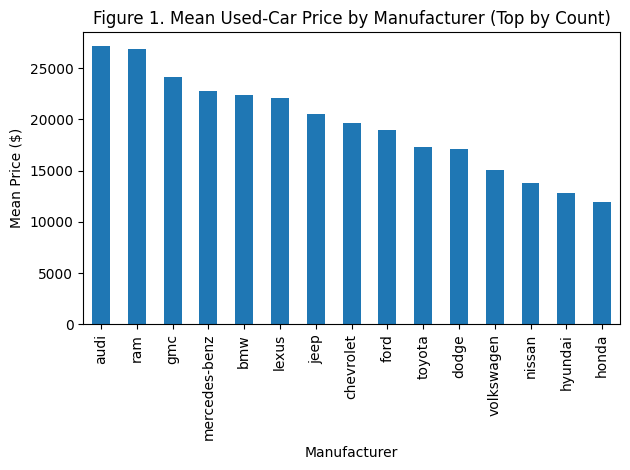

Top manufacturers by count:
 manufacturer
ford             28317
chevrolet        24062
toyota           16581
honda            10480
nissan            8819
bmw               8042
jeep              7948
gmc               7646
ram               6640
dodge             5655
mercedes-benz     5349
volkswagen        5216
hyundai           4938
audi              4730
lexus             4595
Name: count, dtype: int64

Mean price by manufacturer (top):
 manufacturer
audi             27150.167865
ram              26867.999096
gmc              24124.983521
mercedes-benz    22795.318751
bmw              22392.548993
lexus            22113.126659
jeep             20567.997987
chevrolet        19653.409359
ford             19000.579793
toyota           17319.984259
dodge            17144.944828
volkswagen       15105.052531
nissan           13787.334278
hyundai          12862.694411
honda            11975.252004
Name: price, dtype: float64


In [ ]:
# =========================
# 4) Descriptive: mean price by manufacturer (top N by count)
# =========================
TOP_N = 15

man_counts = df["manufacturer"].value_counts().head(TOP_N)
top_mans = man_counts.index

summary_man = (
    df[df["manufacturer"].isin(top_mans)]
    .groupby("manufacturer")["price"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
summary_man.plot(kind="bar")
plt.title("Figure 1. Mean Used-Car Price by Manufacturer (Top by Count)")
plt.xlabel("Manufacturer")
plt.ylabel("Mean Price ($)")
plt.tight_layout()
plt.show()

print("Top manufacturers by count:\n", man_counts)
print("\nMean price by manufacturer (top):\n", summary_man)


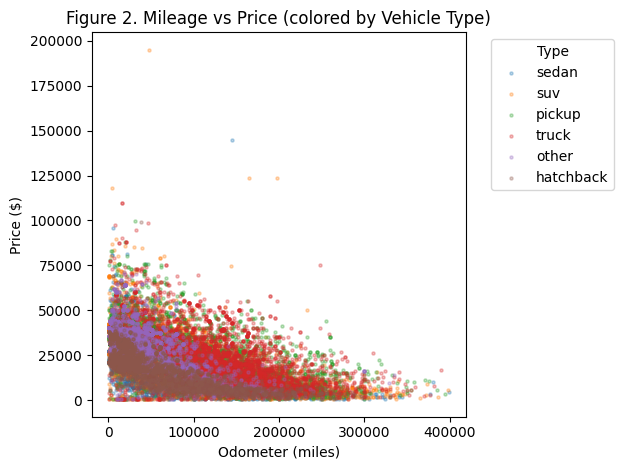

Top vehicle types used in plot: ['sedan', 'suv', 'pickup', 'truck', 'other', 'hatchback']


In [ ]:
# =========================
# 5) Exploratory: odometer vs price, colored by type
# =========================
# For readability, sample if dataset is huge
plot_df = df.copy()
if len(plot_df) > 50000:
    plot_df = plot_df.sample(50000, random_state=RANDOM_SEED)

# Keep only top vehicle types for cleaner plot
top_types = plot_df["type"].value_counts().head(6).index
plot_df = plot_df[plot_df["type"].isin(top_types)]

plt.figure()
for t in top_types:
    sub = plot_df[plot_df["type"] == t]
    plt.scatter(sub["odometer"], sub["price"], s=5, alpha=0.3, label=t)

plt.title("Figure 2. Mileage vs Price (colored by Vehicle Type)")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price ($)")
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("Top vehicle types used in plot:", list(top_types))


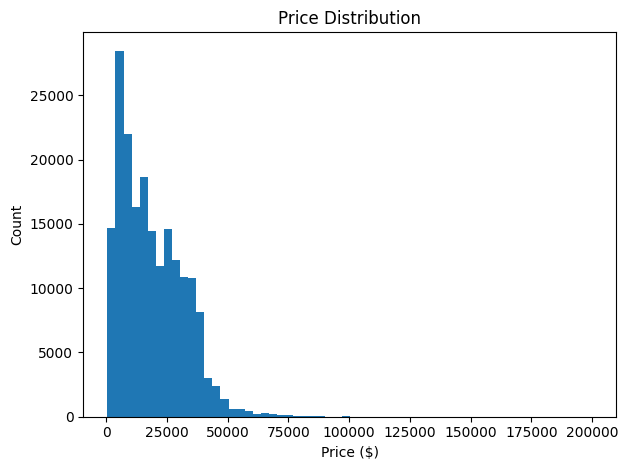

In [ ]:
plt.figure()
plt.hist(df["price"], bins=60)
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
